In [2]:
import os
import pandas

mirna_src_dir = os.getcwd() + "/data/processed/miRNA/"
clinical_src_dir = os.getcwd() + "/data/processed/clinical/"

mirna_tumor_df = pandas.read_csv(mirna_src_dir+'tumor_miRNA.csv')
mirna_normal_df = pandas.read_csv(mirna_src_dir+'normal_miRNA.csv')
clinical_df = pandas.read_csv(clinical_src_dir+'clinical.csv')

print "mirna_tumor_df.shape", mirna_tumor_df.shape
print "mirna_normal_df.shape", mirna_normal_df.shape

"""
Here we select samples to use for our regression analysis
"""
matched_samples = pandas.merge(clinical_df, mirna_normal_df, on='patient_barcode')['patient_barcode']
# print "matched_samples", matched_samples.shape
# merged = pandas.merge(clinical_df, mirna_tumor_df, on='patient_barcode')
# print merged.shape
# print
# print merged['histological_type'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_stage'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_T'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_N'].value_counts().sort_index(axis=0)
# print
# print merged['pathologic_M'].value_counts().sort_index(axis=0)
# print

mirna_tumor_df.shape (513, 1882)
mirna_normal_df.shape (46, 1882)
matched_samples (46,)
(513, 1888)

Lung Acinar Adenocarcinoma                             18
Lung Adenocarcinoma Mixed Subtype                     106
Lung Adenocarcinoma- Not Otherwise Specified (NOS)    320
Lung Bronchioloalveolar Carcinoma Mucinous              5
Lung Bronchioloalveolar Carcinoma Nonmucinous          19
Lung Clear Cell Adenocarcinoma                          2
Lung Micropapillary Adenocarcinoma                      2
Lung Mucinous Adenocarcinoma                            2
Lung Papillary Adenocarcinoma                          23
Lung Signet Ring Adenocarcinoma                         1
Lung Solid Pattern Predominant Adenocarcinoma           5
Mucinous (Colloid) Carcinoma                           10
Name: histological_type, dtype: int64

Stage I         5
Stage IA      133
Stage IB      139
Stage II        1
Stage IIA      50
Stage IIB      70
Stage IIIA     73
Stage IIIB     11
Stage IV       24
Na

## We now create data matrixes from tumor vs normal samples

In [3]:
from sklearn import preprocessing
import numpy as np
X_normal = mirna_normal_df[mirna_normal_df['patient_barcode'].isin(matched_samples)]
X_tumor = mirna_tumor_df[mirna_tumor_df['patient_barcode'].isin(matched_samples)]
X_normal.__delitem__('patient_barcode')
X_tumor.__delitem__('patient_barcode')

X = pandas.concat([X_normal, X_tumor])
# Create labels for 92 samples, first 46 labeled 0 indicating normal tissues, and last 46 labeled 1 for tumor tissues
Y = np.concatenate((-np.ones(46), np.ones(46)), axis=0)

# print 'miRNA null values', X.isnull().sum().sum()
# print 'Y null values', Y.isnull().sum()

print "X_normal.shape", X_normal.shape
print "X_tumor.shape", X_tumor.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
# 
X_scaler = preprocessing.StandardScaler(with_mean=False).fit(X)
X = X_scaler.transform(X)

X_normal.shape (46, 1881)
X_tumor.shape (46, 1881)
Y.shape (92,)


## Perform classification with an L1-regularized Logistic Regression

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=np.random.randint(0, 10000))
print 'X_train', X_train.shape, ', y_train', y_train.shape
print 'X_test', X_test.shape, ', y_test', y_test.shape

model = linear_model.LogisticRegression(C=0.5, penalty="l1", fit_intercept=False, verbose=1)
print model.fit(X_train, y_train)

non_zero_idx = np.nonzero(model.coef_.ravel())[0]
print "\nNon-zero coef:", non_zero_idx.size
df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                       "coefficient": model.coef_.ravel()[non_zero_idx]})
print df.sort(columns='coefficient', ascending=False).head(5)
print df.sort(columns='coefficient', ascending=True).head(5)

print "\nClassification_report on training"
print metrics.classification_report(y_train, model.predict(X_train), labels=[-1, 1], target_names=["normal", "tumor"])
print "classification_report on testing"
print metrics.classification_report(y_test, model.predict(X_test), labels=[-1, 1], target_names=["normal", "tumor"])
print metrics.confusion_matrix(y_test, model.predict(X_test), labels=[-1, 1])

X_train (64, 1881) , y_train (64,)
X_test (28, 1881) , y_test (28,)
[LibLinear]LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

Non-zero coef: 26
    coefficient        mirna
5      0.509565   hsa-mir-21
23     0.390473  hsa-mir-708
7      0.345406  hsa-mir-331
24     0.331437  hsa-mir-7-1
18     0.248365  hsa-mir-625
    coefficient         mirna
17    -0.670006   hsa-mir-598
1     -0.431597   hsa-mir-139
22    -0.362484  hsa-mir-6892
6     -0.238104   hsa-mir-30a
8     -0.234648   hsa-mir-340

Classification_report on training
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00        32
      tumor       1.00      1.00      1.00        32

avg / total       1.00      1.00      1.00        64

classification_report on testing

/Users/jonny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jonny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [11]:
print y_test[0:7]
print np.inner(model.coef_, X_test[0:7])

[ 1.  1.  1.  1. -1.  1.  1.]
[[ 2.65172406  1.34063705  3.95763073  2.96058273 -2.10121534  2.96378596
   0.83204018]]


In [7]:
print "classification_report on rest of tumor patients"
X_tumor_unmatched = mirna_tumor_df[~mirna_tumor_df['patient_barcode'].isin(matched_samples)].dropna(subset=['hsa-mir-96']).copy()
X_tumor_unmatched.__delitem__('patient_barcode')
X_tumor_unmatched = X_scaler.transform(X_tumor_unmatched)
print X_tumor_unmatched.shape

Y_tumor_unmatched = np.array([1,]*X_tumor_unmatched.shape[0], dtype=int)

print metrics.classification_report(Y_tumor_unmatched, model.predict(X_tumor_unmatched), labels=[-1, 1], target_names=["normal", "target"])
print metrics.confusion_matrix(Y_tumor_unmatched, model.predict(X_tumor_unmatched), labels=[-1, 1])

classification_report on rest of tumor patients
(467, 1881)
             precision    recall  f1-score   support

     normal       0.00      0.00      0.00         0
     target       1.00      0.97      0.98       467

avg / total       1.00      0.97      0.98       467

[[  0   0]
 [ 14 453]]


/Users/jonny/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Try to draw a LASSO path

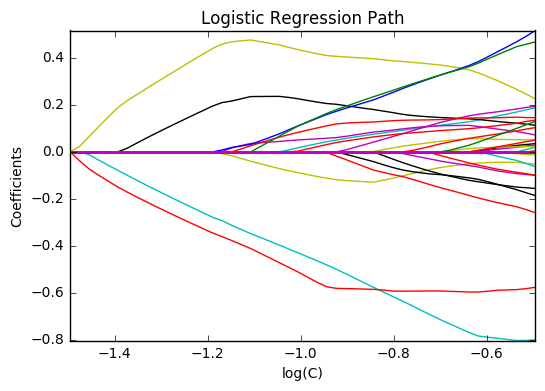

In [28]:
from sklearn.svm import l1_min_c
from matplotlib import pyplot as plt

cs = l1_min_c(X, Y, loss='log') * np.logspace(0, 1)
clf = linear_model.LogisticRegression(C=0.1, penalty='l1', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, Y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

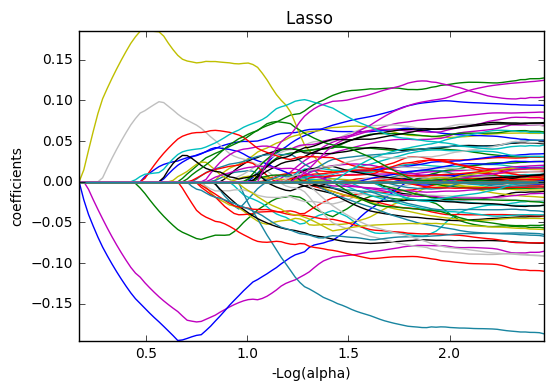

In [61]:
from matplotlib import pyplot as plt
from itertools import cycle

colors = cycle(['r', 'b', 'g', 'c', 'k', 'm', 'y', '0.75', '#1985a0'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)

for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso ')
plt.axis('tight')
plt.show()